In [1]:
!pip install torch torchvision scikit-learn

# 1 Comparing PCA and Autoencoders

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load MNIST dataset
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.14MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 162kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.54MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.35MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
from sklearn.decomposition import PCA
import numpy as np

# Flatten the images for PCA (28x28 = 784)
train_images = train_data.data.view(-1, 28*28).numpy()

# Perform PCA and keep 30 components
pca = PCA(n_components=30)
pca.fit(train_images)

# Transform data to 30 dimensions
train_images_pca = pca.transform(train_images)

# Reconstruct from the 30-dimensional representation
train_images_pca_reconstructed = pca.inverse_transform(train_images_pca)

# Reshape back to the original 28x28
train_images_pca_reconstructed = train_images_pca_reconstructed.reshape(-1, 28, 28)


In [4]:
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 30)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(30, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # Use sigmoid to scale the output to [0, 1] range
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop for autoencoder
def train_autoencoder(model, train_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1)  # Flatten images
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train_autoencoder(model, train_loader, criterion, optimizer, epochs=5)


Epoch [1/5], Loss: 0.0227
Epoch [2/5], Loss: 0.0190
Epoch [3/5], Loss: 0.0110
Epoch [4/5], Loss: 0.0141
Epoch [5/5], Loss: 0.0122


In [5]:
from sklearn.metrics import mean_squared_error

# Flatten original images for comparison
train_images_flatten = train_images.reshape(-1, 784)

# Calculate MSE between original and PCA-reconstructed images
pca_reconstruction_error = mean_squared_error(train_images_flatten, train_images_pca_reconstructed.reshape(-1, 784))
print(f'PCA Reconstruction MSE: {pca_reconstruction_error:.4f}')


PCA Reconstruction MSE: 1178.3380


In [6]:
# Test the autoencoder on a batch of data
dataiter = iter(train_loader)
images, _ = next(dataiter)  # Use next() instead of dataiter.next()
images = images.view(images.size(0), -1)

# Get the reconstructed output
with torch.no_grad():
    reconstructed = model(images)

# Calculate MSE between original and autoencoder-reconstructed images
autoencoder_reconstruction_error = mean_squared_error(images.numpy(), reconstructed.numpy())
print(f'Autoencoder Reconstruction MSE: {autoencoder_reconstruction_error:.4f}')


Autoencoder Reconstruction MSE: 0.0120


Typically, autoencoders are more flexible and can potentially achieve lower reconstruction error due to their non-linear nature, while PCA relies solely on linear transformations.

Notes:
PCA captures only the linear relationships, whereas an autoencoder can capture more complex, non-linear relationships.
The architecture of the autoencoder, learning rate, and number of epochs will impact the performance.

# 2 Standard Autoencoder

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

# Define the Autoencoder
class SimpleAutoencoder(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleAutoencoder, self).__init__()
        # Encoder: input -> hidden layer
        self.encoder = nn.Sequential(
            nn.Linear(28*28, hidden_size),  # One hidden layer with variable size
            nn.ReLU()
        )
        # Decoder: hidden layer -> output
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 28*28),
            nn.Sigmoid()  # Use Sigmoid to keep output in the [0, 1] range
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Training function
def train_autoencoder(hidden_size, epochs=5):
    model = SimpleAutoencoder(hidden_size)
    criterion = nn.MSELoss()  # Reconstruction loss (mean squared error)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for images, _ in train_loader:
            images = images.view(images.size(0), -1)  # Flatten images
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model

# Train the autoencoder for different hidden sizes (x)
hidden_sizes = [64, 128, 256]
models = {size: train_autoencoder(size) for size in hidden_sizes}


Epoch [1/5], Loss: 0.0176
Epoch [2/5], Loss: 0.0088
Epoch [3/5], Loss: 0.0072
Epoch [4/5], Loss: 0.0064
Epoch [5/5], Loss: 0.0054
Epoch [1/5], Loss: 0.0097
Epoch [2/5], Loss: 0.0052
Epoch [3/5], Loss: 0.0037
Epoch [4/5], Loss: 0.0029
Epoch [5/5], Loss: 0.0025
Epoch [1/5], Loss: 0.0063
Epoch [2/5], Loss: 0.0037
Epoch [3/5], Loss: 0.0024
Epoch [4/5], Loss: 0.0021
Epoch [5/5], Loss: 0.0017


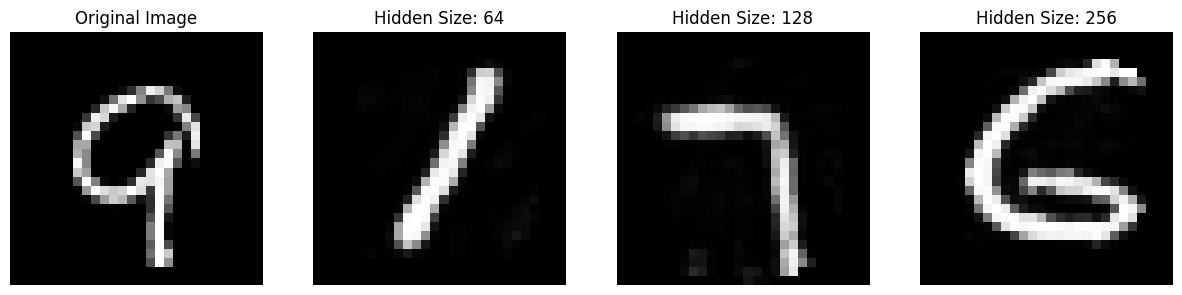

In [8]:
# Test the autoencoder on a test image
def test_autoencoder(model):
    dataiter = iter(test_loader)
    image, _ = next(dataiter)
    image = image.view(1, -1)  # Flatten the image

    # Get the reconstructed output
    with torch.no_grad():
        reconstructed = model(image)

    # Reshape for visualization
    reconstructed = reconstructed.view(28, 28)
    return image.view(28, 28), reconstructed

# Plot original and reconstructed images
def plot_reconstruction(models, hidden_sizes):
    fig, axes = plt.subplots(1, len(hidden_sizes) + 1, figsize=(15, 5))

    # Get the original image
    original, _ = test_autoencoder(models[hidden_sizes[0]])

    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Get reconstructed images for different hidden sizes
    for i, size in enumerate(hidden_sizes):
        _, reconstructed = test_autoencoder(models[size])
        axes[i+1].imshow(reconstructed, cmap='gray')
        axes[i+1].set_title(f'Hidden Size: {size}')
        axes[i+1].axis('off')

# Compare reconstructions for different hidden layer sizes
plot_reconstruction(models, hidden_sizes)


Reconstruction Quality:
By comparing the reconstructions for different hidden sizes, you should notice that larger hidden layers (e.g., 256) provide better reconstructions compared to smaller ones (e.g., 64). This is because a larger hidden layer can capture more features of the input images.

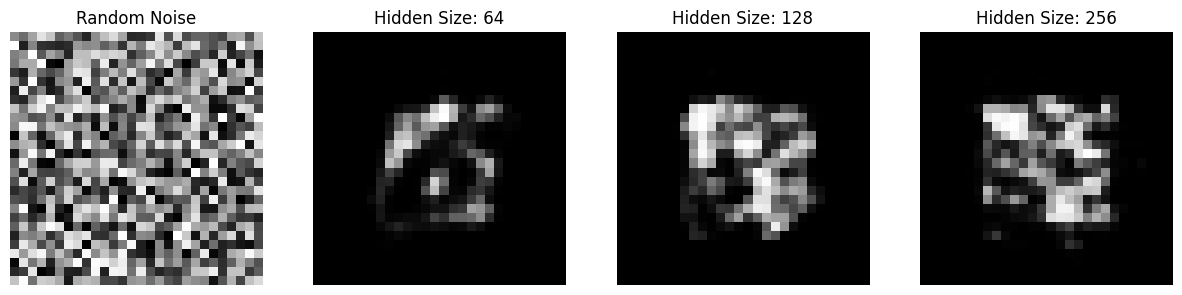

In [9]:
# Create random noise images
def test_random_noise(model, image_size=(28, 28)):
    noise = torch.rand(image_size).view(1, -1)  # Random noise

    with torch.no_grad():
        reconstructed = model(noise)

    reconstructed = reconstructed.view(28, 28)
    return noise.view(28, 28), reconstructed

# Plot noise and reconstructions
def plot_noise_reconstruction(models, hidden_sizes):
    fig, axes = plt.subplots(1, len(hidden_sizes) + 1, figsize=(15, 5))

    # Generate random noise
    noise, _ = test_random_noise(models[hidden_sizes[0]])

    axes[0].imshow(noise, cmap='gray')
    axes[0].set_title('Random Noise')
    axes[0].axis('off')

    # Get reconstructed images for different hidden sizes
    for i, size in enumerate(hidden_sizes):
        _, reconstructed = test_random_noise(models[size])
        axes[i+1].imshow(reconstructed, cmap='gray')
        axes[i+1].set_title(f'Hidden Size: {size}')
        axes[i+1].axis('off')

# Test reconstructions on random noise
plot_noise_reconstruction(models, hidden_sizes)


Random Noise:
Passing random noise images should result in outputs that are typically meaningless and blurry. This is because the autoencoder is trained specifically to reconstruct digit images, so it will not generalize well to completely different patterns

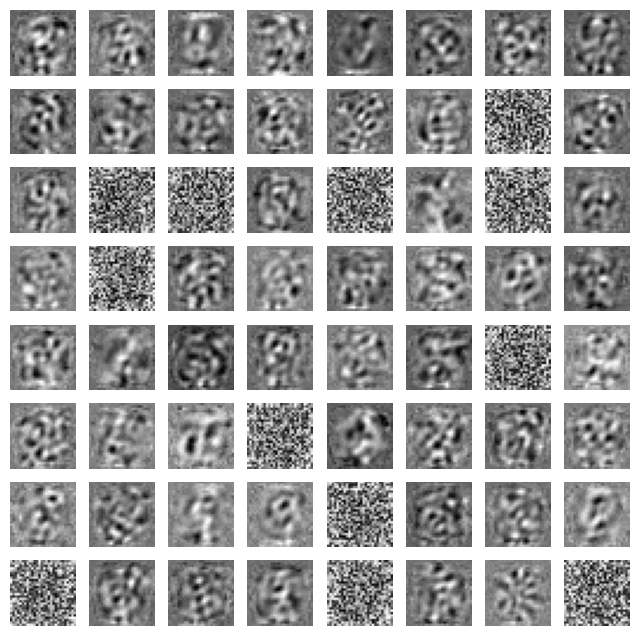

In [10]:
# Visualize learned filters (weights) for the hidden layer
def visualize_filters(model):
    filters = model.encoder[0].weight.data  # Access the weights of the hidden layer

    # Plot the filters
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        if i < filters.size(0):
            filter_img = filters[i].view(28, 28)  # Reshape the weights to 28x28
            ax.imshow(filter_img, cmap='gray')
        ax.axis('off')
    plt.show()

# Visualize filters for hidden size 64
visualize_filters(models[64])


Visualizing Filters:
The filters (weights) of the hidden layer can be visualized as small patches, and these often resemble basic features such as edges or small strokes, indicating that the autoencoder has learned to extract simple features from the input images.

# 3 Sparse Autoencoders

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Over-complete Autoencoder with Sparsity Regularization
class SparseAutoencoder(nn.Module):
    def __init__(self, hidden_size, sparsity_weight=1e-5):
        super(SparseAutoencoder, self).__init__()
        self.sparsity_weight = sparsity_weight
        # Encoder: input -> hidden layer
        self.encoder = nn.Sequential(
            nn.Linear(28*28, hidden_size),
            nn.ReLU()
        )
        # Decoder: hidden layer -> output
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def loss_function(self, x, reconstructed, encoded):
        # Reconstruction loss
        mse_loss = nn.MSELoss()(reconstructed, x)

        # L1 Penalty on hidden layer activations (sparsity)
        l1_penalty = self.sparsity_weight * torch.sum(torch.abs(encoded))

        # Total loss is reconstruction loss + L1 penalty
        total_loss = mse_loss + l1_penalty
        return total_loss

# Training function with sparsity regularization
def train_sparse_autoencoder(hidden_size, sparsity_weight, epochs=5):
    model = SparseAutoencoder(hidden_size, sparsity_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.view(images.size(0), -1)  # Flatten the images
            optimizer.zero_grad()

            # Forward pass
            encoded, reconstructed = model(images)

            # Compute loss
            loss = model.loss_function(images, reconstructed, encoded)
            total_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

    return model

# Train Sparse Autoencoder with different sparsity weights
hidden_size = 1024  # Over-complete AE (more units than input dimension)
sparsity_weights = [1e-5, 1e-4, 1e-3]  # Vary the degree of sparsity

# Train models for each sparsity weight
sparse_models = {weight: train_sparse_autoencoder(hidden_size, weight) for weight in sparsity_weights}


Epoch [1/5], Loss: 0.0569
Epoch [2/5], Loss: 0.0324
Epoch [3/5], Loss: 0.0277
Epoch [4/5], Loss: 0.0252
Epoch [5/5], Loss: 0.0236
Epoch [1/5], Loss: 0.1690
Epoch [2/5], Loss: 0.1037
Epoch [3/5], Loss: 0.0828
Epoch [4/5], Loss: 0.0748
Epoch [5/5], Loss: 0.0712
Epoch [1/5], Loss: 0.1770
Epoch [2/5], Loss: 0.1037
Epoch [3/5], Loss: 0.0827
Epoch [4/5], Loss: 0.0748
Epoch [5/5], Loss: 0.0712


1. Average Hidden Layer Activations:

For the standard autoencoder, the average hidden activations will be relatively high as all the hidden units are actively involved in the reconstruction.
In the sparse autoencoder, as we increase the sparsity weight, more activations will approach zero, leading to fewer hidden units being active.

2. Learned Filters Visualization:

In the standard autoencoder, the filters tend to capture more global features (edges, blobs, etc.) across the input image.
In the sparse autoencoder, as sparsity increases, the filters will become more localized and focus on smaller, distinct features (e.g., parts of digits) because the network is encouraged to use fewer units to represent the input.

# 4 Denoising Autoencoder

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

# Add Gaussian noise to the input images
def add_noise(imgs, noise_factor):
    noisy_imgs = imgs + noise_factor * torch.randn(*imgs.shape)
    noisy_imgs = torch.clip(noisy_imgs, 0., 1.)  # Ensure the values stay within [0, 1]
    return noisy_imgs

# Define a Denoising Autoencoder with one hidden layer
class DenoisingAutoencoder(nn.Module):
    def __init__(self, hidden_size=128):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 28*28),
            nn.Sigmoid()  # Ensure output is in [0, 1] range
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load MNIST dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

# Training function for Denoising AE
def train_denoising_autoencoder(noise_factor, hidden_size=128, epochs=5):
    model = DenoisingAutoencoder(hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()  # Reconstruction loss

    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.view(images.size(0), -1)  # Flatten images
            noisy_images = add_noise(images, noise_factor)  # Corrupt images with noise

            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, images)  # Compare noisy input to clean images
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

    return model

# Train the Denoising Autoencoder
noise_factor = [0.3, 0.5, 0.8, 0.9]  # Starting noise level
dae_model = []
for noise_fact in noise_factor:
  model = train_denoising_autoencoder(noise_fact, hidden_size=128)
  dae_model.append(model)


Epoch [1/5], Loss: 0.0332
Epoch [2/5], Loss: 0.0132
Epoch [3/5], Loss: 0.0103
Epoch [4/5], Loss: 0.0092
Epoch [5/5], Loss: 0.0086
Epoch [1/5], Loss: 0.0396
Epoch [2/5], Loss: 0.0210
Epoch [3/5], Loss: 0.0183
Epoch [4/5], Loss: 0.0172
Epoch [5/5], Loss: 0.0167
Epoch [1/5], Loss: 0.0488
Epoch [2/5], Loss: 0.0332
Epoch [3/5], Loss: 0.0306
Epoch [4/5], Loss: 0.0297
Epoch [5/5], Loss: 0.0292
Epoch [1/5], Loss: 0.0498
Epoch [2/5], Loss: 0.0358
Epoch [3/5], Loss: 0.0337
Epoch [4/5], Loss: 0.0328
Epoch [5/5], Loss: 0.0322


Standard AE with noisy inputs:


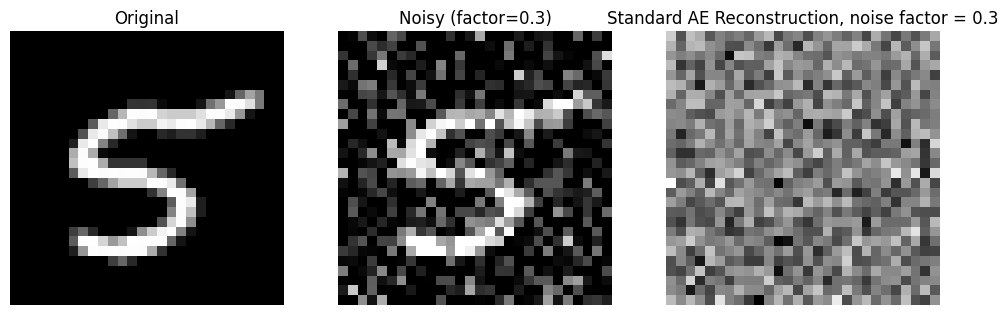

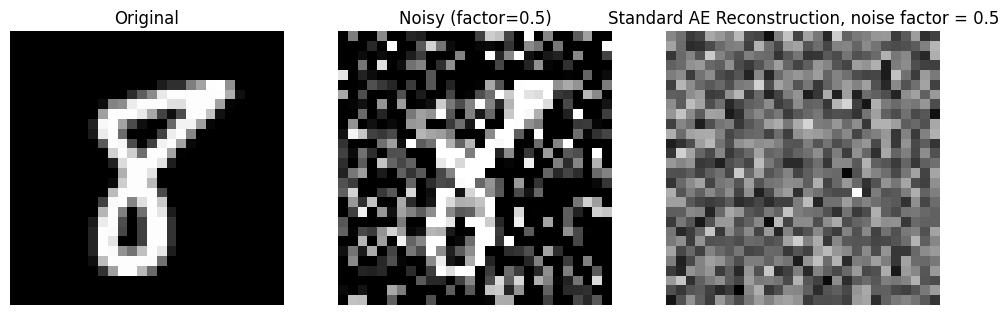

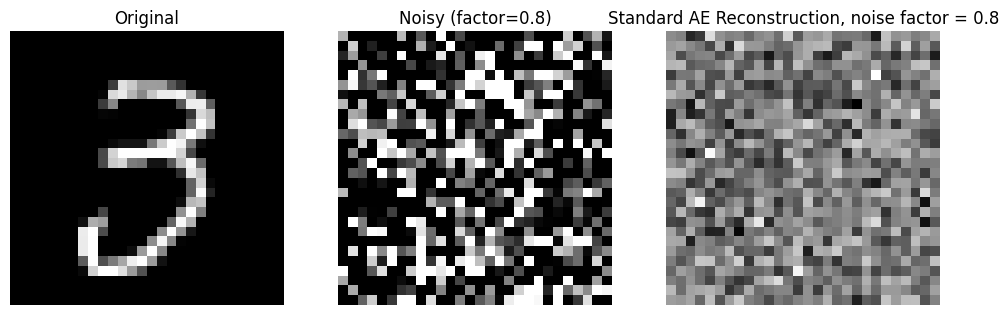

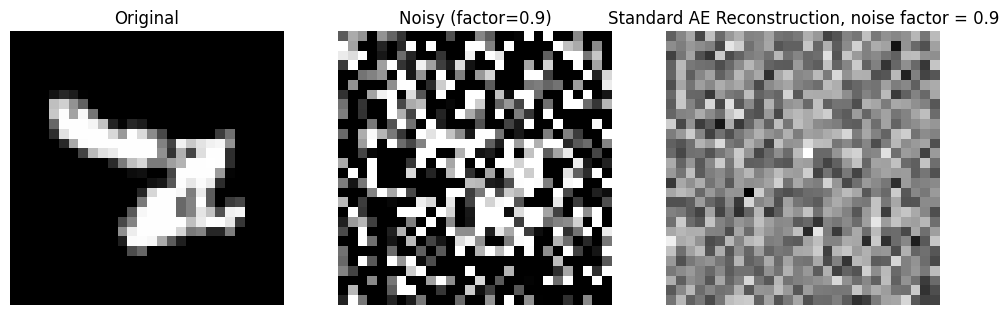

In [22]:
# Function to test noisy inputs on standard AE
def test_on_noisy_images(model, noise_factor):
    dataiter = iter(test_loader)
    original_image, _ = next(dataiter)
    original_image = original_image.view(1, -1)  # Flatten the image

    noisy_image = add_noise(original_image, noise_factor)

    with torch.no_grad():
        reconstructed = model(noisy_image)

    return original_image.view(28, 28), noisy_image.view(28, 28), reconstructed.view(28, 28)

# Plot results: Original, Noisy, Reconstructed
def plot_noisy_reconstruction(model, noise_factor, title="Reconstruction"):
    original, noisy, reconstructed = test_on_noisy_images(model, noise_factor)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(noisy, cmap='gray')
    axes[1].set_title(f'Noisy (factor={noise_factor})')
    axes[1].axis('off')

    axes[2].imshow(reconstructed, cmap='gray')
    axes[2].set_title(f'{title}')
    axes[2].axis('off')
    plt.show()

# Test noisy inputs on standard AE
print("Standard AE with noisy inputs:")
plot_noisy_reconstruction(Autoencoder(), noise_factor=0.3, title="Standard AE Reconstruction, noise factor = 0.3")
plot_noisy_reconstruction(Autoencoder(), noise_factor=0.5, title="Standard AE Reconstruction, noise factor = 0.5")
plot_noisy_reconstruction(Autoencoder(), noise_factor=0.8, title="Standard AE Reconstruction, noise factor = 0.8")
plot_noisy_reconstruction(Autoencoder(), noise_factor=0.9, title="Standard AE Reconstruction, noise factor = 0.9")


Denoising AE with noise factor 0.3:


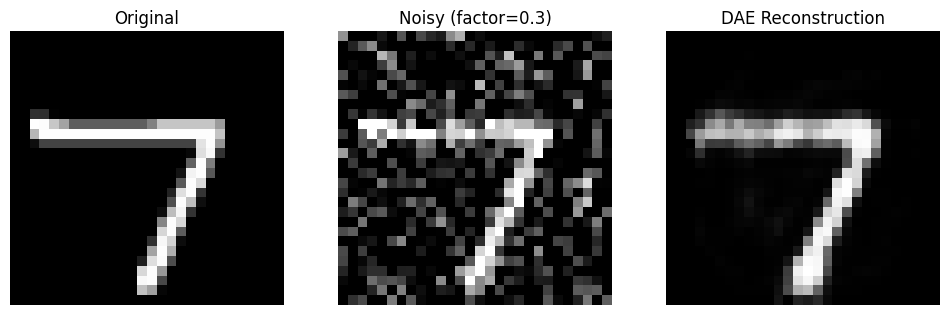

Denoising AE with noise factor 0.5:


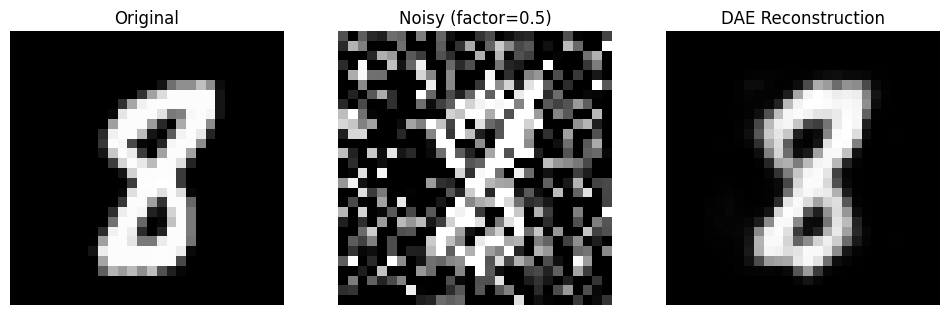

Denoising AE with noise factor 0.8:


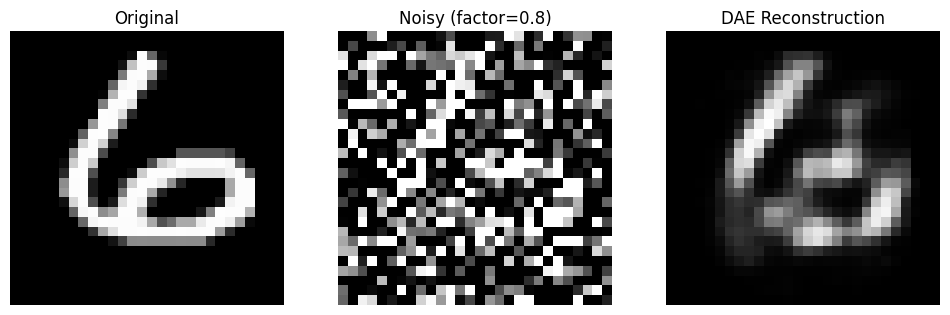

Denoising AE with noise factor 0.9:


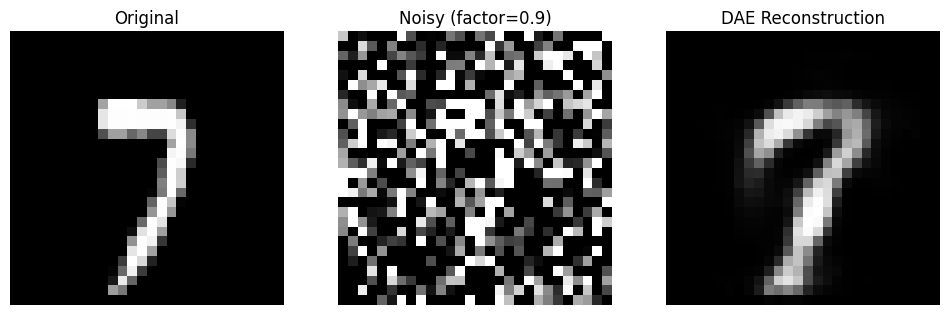

In [23]:
# Function to test noisy inputs on DAE
def test_denoising_ae(dae_model, noise_factor):
    original, noisy, reconstructed = test_on_noisy_images(dae_model, noise_factor)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(noisy, cmap='gray')
    axes[1].set_title(f'Noisy (factor={noise_factor})')
    axes[1].axis('off')

    axes[2].imshow(reconstructed, cmap='gray')
    axes[2].set_title('DAE Reconstruction')
    axes[2].axis('off')
    plt.show()

# Test DAE on different noise levels
noise_levels = [0.3, 0.5, 0.8, 0.9]
for i in range(len(noise_levels)):
    print(f"Denoising AE with noise factor {noise_levels[i]}:")
    test_denoising_ae(dae_model[i], noise_levels[i])


Observations on Noise Levels:
1. Standard AE Performance:
The standard autoencoder, when tested on noisy images, will fail to reconstruct clean images properly. As the noise level increases, the reconstructed image becomes more distorted since the model wasn’t trained to handle noise.

2. Denoising AE Performance:
The Denoising Autoencoder, on the other hand, will perform much better as it was explicitly trained to denoise the input. However, as the noise level becomes too high (e.g., 0.9), even the DAE will struggle, leading to blurry or incomplete reconstructions.



Filters for Denoising AE:


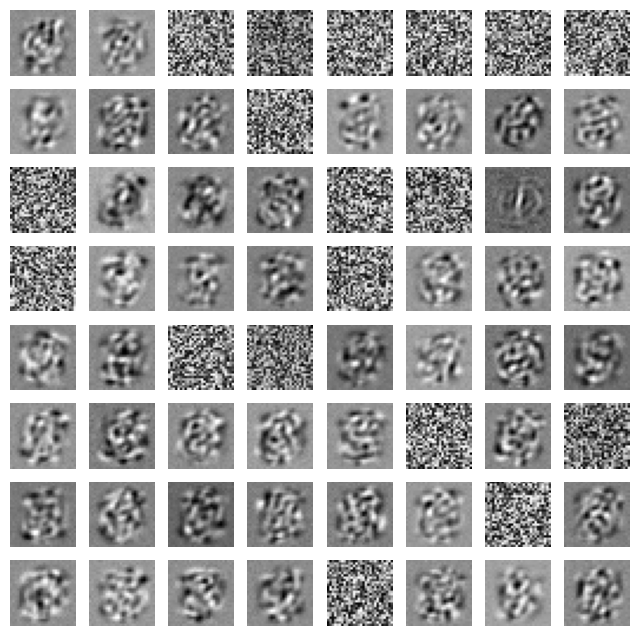

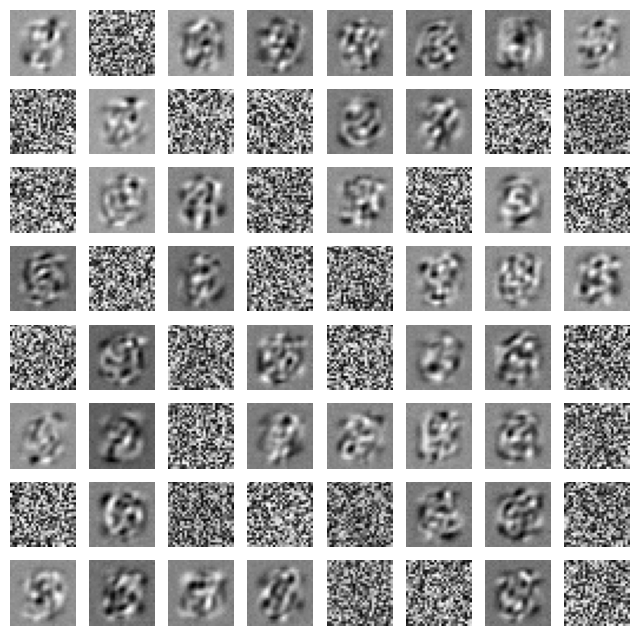

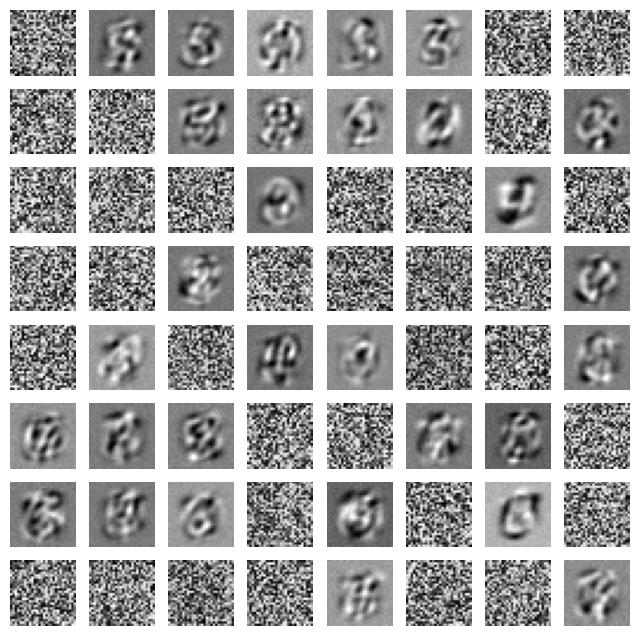

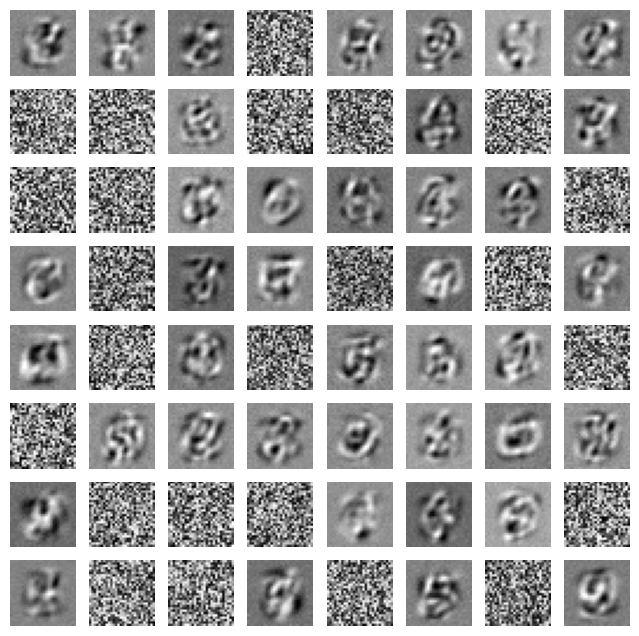

Filters for Standard AE:


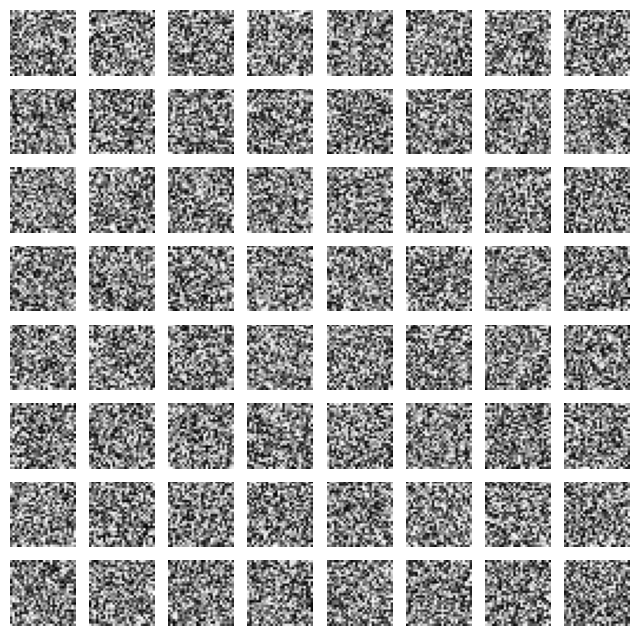

In [25]:
# Visualize learned filters (weights) of the Denoising Autoencoder
print("Filters for Denoising AE:")
visualize_filters(dae_model[0])
visualize_filters(dae_model[1])
visualize_filters(dae_model[2])
visualize_filters(dae_model[3])

# Compare with Standard AE filters (assuming you have trained and visualized standard AE)
print("Filters for Standard AE:")
visualize_filters(Autoencoder())


Observations on Filters:
1. Standard AE Filters:
The filters learned by the standard autoencoder typically represent global features, such as edges or parts of digits, and are focused on reconstructing clean input images.

2. Denoising AE Filters:
The filters learned by the denoising autoencoder are often more robust to noise. They tend to capture localized features and can sometimes be more complex, reflecting the network’s ability to reconstruct the original image even when parts of it are corrupted.


Conclusion:
 1. Standard AE vs DAE on Noisy Inputs: The standard AE performs poorly on noisy inputs, while the DAE excels at reconstructing clean images from noisy data, especially at moderate noise levels.

2. Effect of Noise Levels: As noise increases, both models struggle, but the DAE consistently outperforms the standard AE.

3. Filters Comparison: The filters learned by the DAE are more localized and robust, while those of the standard AE focus on clean input

# 5 Manifold Learning

Adding noise to input space:


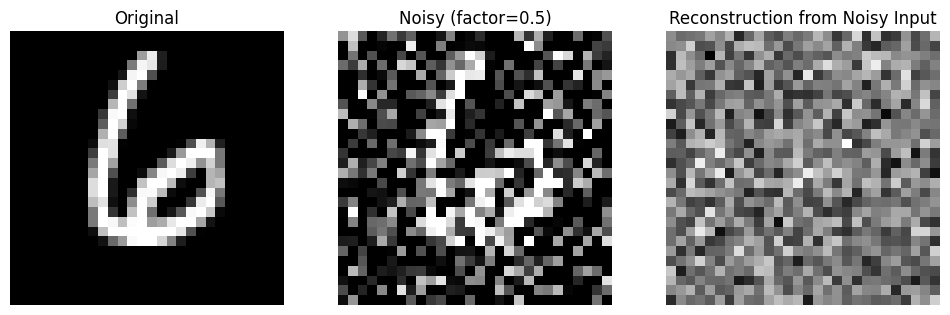

In [29]:
# Function to add noise to the input image
def add_noise_to_input(image, noise_factor=0.5):
    noisy_image = image + noise_factor * torch.randn_like(image)
    noisy_image = torch.clip(noisy_image, 0., 1.)  # Ensure values are in [0, 1]
    return noisy_image

# Test the effect of adding noise to the input image
def test_input_space_noise(model, noise_factor):
    dataiter = iter(test_loader)
    original_image, _ = next(dataiter)
    original_image = original_image.view(1, -1)  # Flatten the image

    noisy_image = add_noise_to_input(original_image, noise_factor)

    with torch.no_grad():
        reconstructed = model(noisy_image)

    return original_image.view(28, 28), noisy_image.view(28, 28), reconstructed.view(28, 28)

# Visualize the result of adding noise to the input space
print("Adding noise to input space:")
plot_noisy_reconstruction(Autoencoder(), noise_factor=0.5, title="Reconstruction from Noisy Input")


Observations:
1. When you randomly perturb a point in this 784-dimensional space, the resulting point is likely to fall outside the manifold of valid digits. This is because the manifold of MNIST digits occupies only a small region of the high-dimensional input space.
2. Adding random noise to the input space will distort the image, leading to unrecognizable shapes or noise, because there’s no guarantee that small perturbations in pixel values correspond to meaningful variations on the manifold of digits.

Explanation:
1. Why does this happen?
The manifold hypothesis suggests that high-dimensional data (like images) often lie on a much lower-dimensional manifold within the input space. Random noise moves the data off this manifold, resulting in distorted or nonsensical images.

2. Result: The image will often become a noisy, unrecognizable pattern rather than a valid digit when we add random noise to the input space.

## 2. Latent Space Noise (Manifold Learning):
Now, we'll train an AE with a bottleneck layer of size 8 (as specified) and experiment with adding noise to the latent representation (8-dimensional space) instead of the input. We'll then reconstruct the data from this perturbed latent space and observe how the reconstructions change.

Configuration of AE:
Encoder: 784 (input) → 64 → 8 (latent space)
Decoder: 8 → 64 → 784 (output)

In [31]:
# Define Autoencoder with latent space of size 8
class SmallLatentAE(nn.Module):
    def __init__(self):
        super(SmallLatentAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 784),
            nn.Sigmoid()  # Output in the range [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Train the Autoencoder
def train_small_ae(epochs=5):
    model = SmallLatentAE()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.view(images.size(0), -1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

    return model

# Train the AE
small_latent_ae = train_small_ae(epochs=5)


Epoch [1/5], Loss: 0.0539
Epoch [2/5], Loss: 0.0348
Epoch [3/5], Loss: 0.0315
Epoch [4/5], Loss: 0.0305
Epoch [5/5], Loss: 0.0298


## Adding Noise to the Latent Representation:
After training the model, we can add random noise to the 8-dimensional latent representation of an image and observe how this affects the reconstructed output.

Adding noise to latent space:


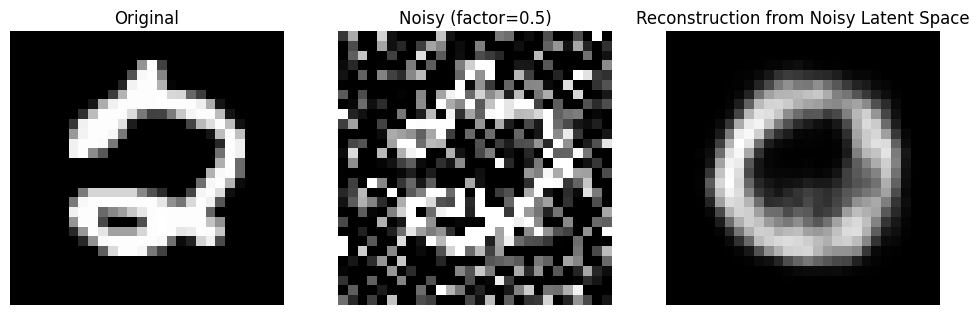

In [32]:
# Function to add noise to latent space
def add_noise_to_latent_space(encoded, noise_factor):
    noisy_encoded = encoded + noise_factor * torch.randn_like(encoded)
    return noisy_encoded

# Test the effect of adding noise to the latent space
def test_latent_space_noise(model, noise_factor):
    dataiter = iter(test_loader)
    original_image, _ = next(dataiter)
    original_image = original_image.view(1, -1)  # Flatten the image

    with torch.no_grad():
        encoded = model.encoder(original_image)  # Get latent representation
        noisy_encoded = add_noise_to_latent_space(encoded, noise_factor)
        reconstructed = model.decoder(noisy_encoded)  # Reconstruct from noisy latent space

    return original_image.view(28, 28), reconstructed.view(28, 28)

# Visualize the result of adding noise to latent space
print("Adding noise to latent space:")
plot_noisy_reconstruction(small_latent_ae, noise_factor=0.5, title="Reconstruction from Noisy Latent Space")


Observations on Latent Space Noise:

Why does the reconstruction remain a valid digit?
The latent space of the autoencoder is a compressed representation of the data that captures essential features. When you add a small amount of noise to the latent space, the network is still able to reconstruct something that looks like a valid digit because you’re still close to the manifold of digit representations. This is different from the input space, where adding noise leads to unstructured images.


Effect of Different Noise Levels:

Small noise (e.g., 0.1 or 0.2): The reconstructed digit remains similar to the original digit but might have some slight variations or blurriness.

Larger noise (e.g., 0.5 or higher): The reconstruction starts to deviate more from the original image but still remains a valid digit, though it may resemble a different digit entirely.

Very large noise (e.g., 1.0 or higher): The reconstruction becomes less recognizable, and the digit may start to lose its form entirely.


Relating to Manifold Learning:
Manifold Hypothesis: The MNIST digits lie on a lower-dimensional manifold within the high-dimensional input space. The AE’s bottleneck forces the network to learn this manifold in the form of a compressed latent representation. Small perturbations in this latent space still correspond to valid digits, but large perturbations can move the point off the manifold, leading to poor reconstructions.

Noise in Input Space vs. Latent Space:

In the input space, random perturbations are unlikely to stay on the digit manifold, resulting in noisy, unrecognizable images.
In the latent space, small perturbations still correspond to valid digits, because the AE has learned to encode the meaningful structure of the data in this space

## Conclusion:
Input Space Noise: Adding random noise to the input space leads to distorted, unrecognizable images, as the noise moves the data point away from the digit manifold.

Latent Space Noise: Adding noise to the latent representation results in reconstructed digits that are still valid, though they may differ slightly from the original. This demonstrates the autoencoder’s ability to learn a meaningful, compressed representation of the data manifold.

Manifold Learning: The autoencoder effectively captures the manifold of digit representations, and small perturbations in this latent space correspond to small changes in the digit. Large perturbations move the representation further from the manifold, resulting in poorer reconstructions.

# 6 Convolutional Autoencoders

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder: Conv layers without padding but carefully chosen dimensions
        self.encoder_conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.encoder_pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.encoder_conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.encoder_pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.encoder_conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        self.encoder_pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)

        # Decoder: Deconv and Unpooling layers
        self.decoder_unpool3 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_conv3 = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1)

        self.decoder_unpool2 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_conv2 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1)

        self.decoder_unpool1 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_conv1 = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x, indices1 = self.encoder_pool1(torch.relu(self.encoder_conv1(x)))
        x, indices2 = self.encoder_pool2(torch.relu(self.encoder_conv2(x)))
        x, indices3 = self.encoder_pool3(torch.relu(self.encoder_conv3(x)))

        # Decoder
        x = self.decoder_unpool3(x, indices3, output_size=torch.Size([x.size(0), 16, 5, 5]))
        x = torch.relu(self.decoder_conv3(x))

        x = self.decoder_unpool2(x, indices2, output_size=torch.Size([x.size(0), 16, 14, 14]))
        x = torch.relu(self.decoder_conv2(x))

        x = self.decoder_unpool1(x, indices1, output_size=torch.Size([x.size(0), 8, 28, 28]))
        x = torch.sigmoid(self.decoder_conv1(x))

        return x

# Instantiate the model
model = ConvAutoencoder()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_conv_ae(model, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in train_loader:
            optimizer.zero_grad()
            # Forward pass
            reconstructed = model(images)
            loss = criterion(reconstructed, images)
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

    return model

# Train the Convolutional Autoencoder for 5 epochs
trained_cae = train_conv_ae(model, num_epochs=5)


Epoch [1/5], Loss: 0.0453
Epoch [2/5], Loss: 0.0101
Epoch [3/5], Loss: 0.0075
Epoch [4/5], Loss: 0.0063
Epoch [5/5], Loss: 0.0057


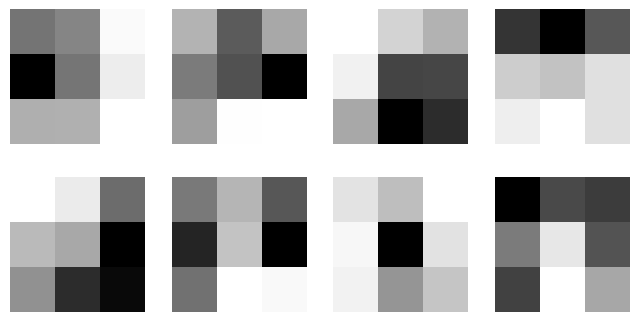

In [37]:
import matplotlib.pyplot as plt

# Get the weights of the first layer in the decoder (conv transpose layer)
decoder_weights = model.decoder_conv1.weight.data.cpu()

# Plot the weights as images
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(decoder_weights[i][0], cmap='gray')
    ax.axis('off')

plt.show()


Observations from Decoder Weights:

1. Structure: The filters often exhibit localized patterns, resembling edges or blobs, similar to the filters in convolutional networks. This shows the network learns features like lines, edges, and textures that are useful for reconstructing images from the latent space.

2. Similarity to Encoder Weights: Often, the decoder weights resemble the encoder’s filters in reverse, as the decoder is effectively learning to reverse the convolution operation performed during encoding.

3. Effect of Sparsity: If sparsity is applied, the learned filters may look sparser (i.e., have more zero activations), with fewer non-zero weights, reflecting the sparsity constraint applied to the latent representations.


## Conclusion:
1. Reconstruction Error:
Decreases steadily across epochs, showing that the model converges and learns effective representations of the MNIST data.

2. Decoder Weights: The learned filters are interpretable as edge and texture detectors, which are critical for reconstructing the digit images from their compressed latent representation.